In [1]:
# %load_ext autoreload
# %autoreload 2

from IPython.lib.deepreload import reload as dreload
import os
import sys

import numpy as np
import torch
import torch.optim as optim
import torch.utils.data as dt

from skimage import io, measure
import matplotlib.pyplot as plt

from tifffile import imread, imsave
from stackview import orthogonal as imshow 
import warnings
warnings.filterwarnings("ignore")


if not torch.cuda.is_available():
    raise ValueError("GPU not found, code will run on CPU and can be extremely slow!")
else:
    device = torch.device("cuda:0")

import time
from glob import glob
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    LearningRateMonitor,
    ModelCheckpoint,
    EarlyStopping,
)

sys.path.append("../../gap/")
from GAP_3DUNET_ResBlock import UN
from BinomDataset import BinomDataset3D
from inference import sample_image

# Training

### Loading the data
_________________

We load the data. We can use the full dataset for training, since this is self-supervised and we do not require ground truth.

In [2]:
DIRPATH = "../../../Data/sted GAP test/"
filePaths = [os.path.join(DIRPATH, f) for f in os.listdir(DIRPATH) if f.endswith('.tif')]
fileNames = [os.path.splitext(os.path.basename(f))[0] for f in filePaths]

dataList = []
channelList = []

# load and frint the information of the data
print(f"{'ID':<4}{'NAME':<24}{'SHAPE':<4}")
for idx, name in enumerate(fileNames):
    data = imread(filePaths[idx])
    if len(data.shape) == 3: data = data[:, None, ...]
    data = data.swapaxes(0,1)
    dataList.append(data)
    channelList.append(data.shape[0])
    print(f"{idx:<3}{name[28:]:<25}{data.shape}")

ID  NAME                    SHAPE
0   405Pwr20                (2, 504, 512, 512)
1   405Pwr50                (2, 504, 512, 512)
2   BlankA                  (2, 504, 512, 512)
3   BlankB                  (2, 504, 512, 512)
4   LineAccu1               (3, 517, 512, 512)
5   LineAccu16              (3, 517, 512, 512)
6   LineAccu4               (3, 517, 512, 512)
7   Series049               (3, 11, 512, 512)
8   STEDAccu16 LocationB    (1, 504, 512, 512)
9   STEDAccu16              (1, 504, 512, 512)
10  STEDBlankAccu16         (1, 504, 512, 512)


In [3]:
ID = 4
CHANNEL = 0
NAME = fileNames[ID][28:]
data = dataList[ID][CHANNEL]
# imshow(data, colormap="magma", display_max=3)
print(data.shape)

(517, 512, 512)


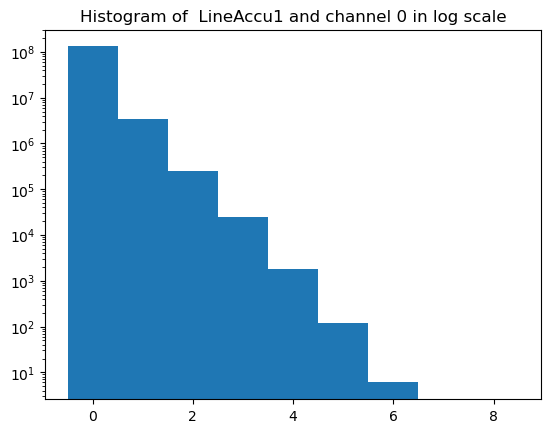

In [4]:
# plot the histogram of the data in log scale
_ = plt.hist(data.flatten(), bins=np.arange(10)-0.5, log=True)
plt.title(f"Histogram of {NAME} and channel {CHANNEL} in log scale")
plt.show()

In [8]:
def psnrToString(inp):
    if inp < 0:
        return "m" + str(-inp)
    else:
        return str(inp)


# we set the pseudo PSNR range used for splitting the images into input and target
unitThickness = 32
windowSize = (32, 128, 128)
WINDOWSIZESTR = "x".join(map(str, windowSize))
minpsnr = -40
maxpsnr = -5
batch_size = 16

name = f"{NAME}_C{CHANNEL}_PSNR{psnrToString(minpsnr)}to{psnrToString(maxpsnr)}_WIN{WINDOWSIZESTR}"
CHECKPOINT_PATH = "./models/"

print(name)

 LineAccu1_C0_PSNRm40tom5_WIN32x128x128


In [9]:
maxepochs = 2000  # train longer for better results
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    
print('device:', device)

# Create pytorch dataset
dataset = BinomDataset3D(
    data[: round(data.shape[0] * 0.8)],
    unitThickness=unitThickness,
    windowSize=windowSize,
    rand_crop=True,
    minPSNR=minpsnr,
    maxPSNR=maxpsnr,
)

val_dataset = BinomDataset3D(
    data[: round(data.shape[0] * 0.8)],
    unitThickness=unitThickness,
    windowSize=windowSize,
    rand_crop=True,
    minPSNR=minpsnr,
    maxPSNR=maxpsnr,
)

# Create pytorch dataloader for training and validation sets
train_loader = dt.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=False,
    num_workers=12,
)
val_loader = dt.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    pin_memory=False,
    num_workers=12,
)

img = next(iter(val_loader))

print(img.shape)


trainer = pl.Trainer(
    accelerator='gpu',
    devices="auto",
    default_root_dir=os.path.join(CHECKPOINT_PATH, name),
    gradient_clip_val=0.5,
    max_epochs=maxepochs,
    callbacks=[
        ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss"),
        LearningRateMonitor("epoch"),
        EarlyStopping("val_loss", patience=2000),
    ],
)

model = UN(channels=1, levels=10, depth=6, start_filts=32, up_mode="transpose").to(
    device
)

device: cuda:0
torch.Size([16, 2, 32, 128, 128])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
trainer.fit(model, train_loader, val_loader)
trainer.save_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | conv_final | Conv3d     | 33    
1 | down_convs | ModuleList | 94.3 M
2 | up_convs   | ModuleList | 33.9 M
------------------------------------------
128 M     Trainable params
0         Non-trainable params
128 M     Total params
512.898   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Denoising

In [ ]:
model = UN.load_from_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt').to(device)

In [ ]:
dataTest = imread('./data/testData.tif')[:1]     # to speed things up, we are only doing the first image
dataTestGT =imread('./data/testDataGT.tif')[:1]
dataTest.shape

In [ ]:
outputs = []
for inp, gt in zip(dataTest, dataTestGT):  
    inpT = torch.from_numpy(inp.astype(np.float32)).to(device)
    # We have to apply softmax over pixels
    out = torch.exp(model(inpT[None,None,...]).detach().cpu())
    out = inp.sum() * out / out.sum()
    outputs.append(out.numpy()[0,0])
    
    print(gt.max(), gt.min(), gt.std(), np.percentile(gt,99.9), np.percentile(gt,50))
    
    inp = inp/inp.mean()
    out = out/out.mean()
    gt = gt/gt.mean()
    vmax = np.percentile(gt,99.9)
    
    plt.figure(figsize=(7,7))
    plt.imshow(inp[:500,:500],vmin = 0, vmax = vmax, cmap = "inferno")
    plt.title('inp')
    plt.show()
    
    plt.figure(figsize=(7,7))
    plt.imshow(out[0,0][:500,:500],vmin = 0,vmax = vmax, cmap = "inferno")
    plt.title('out')
    plt.show()
    
    plt.figure(figsize=(7,7))
    plt.imshow(gt[:500,:500],vmin = 0,vmax = vmax, cmap = "inferno")
    plt.title('GT')
    plt.show()


In [ ]:
outputs = np.array(outputs)
imsave('data/output.tif',outputs, imagej = True)

# Sampling images

In [ ]:
import matplotlib.image as mpimg
import time
import numpy as np

# We are starting with an image containing zeros,
# i.e., sampling from scratch

# we just have 1 channel
channels = 1
# we can sample multiple images at the same time in a batch
batch_size = 1
# for best results this should correspond to training pach size
pixels_x = 256
pixels_y = 256

inp_img =  torch.zeros(batch_size ,channels, pixels_y, pixels_x).to(device)


for i in range(1):
    

    startTime = time.time()
    
    # sampling the image(s)
    denoised, photons, stack, iterations = sample_image(inp_img,
                                                        model, 
                                                        beta = 0.05,
                                                        save_every_n = 10,
                                                        max_psnr = -5)

    
    # In case we do multiple images in a batch, we show all of them.
    for j in range(denoised.shape[0]):
#         print(iterations)

            print(denoised.shape)
            plt.figure(figsize = (5,5))
            plt.imshow(denoised[j,0], cmap='inferno', vmin = 0,
                       vmax = np.percentile(denoised[j],99.99))
            plt.title('Denoisied')
            plt.show()
            
            plt.figure(figsize = (5,5))
            plt.imshow(photons[j,0], cmap='inferno', vmin = 0,
                       vmax = np.percentile(photons[j],99.99))
            plt.title('Photon counts')
            plt.show()
            
            
    
    print('_______________________________________', iterations)
    
    
    
    
    endTime = time.time()
    elapsedTime = endTime - startTime
    print ('time (s):', elapsedTime, 'time per image (s)', elapsedTime/denoised.shape[0])
   

## Looking at the intermediate outputs

In [ ]:
stack[0].shape
for i in range(len(stack)):
    im = stack[i]
    print(i)
    plt.figure(figsize = (12,12))
    plt.imshow(im,cmap ='inferno', vmax = 0.9)
    plt.title('left: Photon counts, right: Denoised')
    plt.show()